DSC160 Data Science and the Arts - Twomey - Spring 2020 - [dsc160.roberttwomey.com](http://dsc160.roberttwomey.com)

# Advanced Audio Features

This notebook demonstrates advanced audio features including frequency transforms (Fourier Transform, Constant-Q Transform), MFCCs, Spectral Statistics (spectral peak, spectral bandwidth, spectral rolloff), and Chroma and pitch band energy.

It depends on the [numpy](https://numpy.org/), [matplotlib](https://matplotlib.org/), [seaborn](https://seaborn.pydata.org/), and [LibROSA](https://librosa.github.io/librosa/) libraries. 

The examples are adapted from the tutorials at [musicinformationretrieval.com](musicinformationretrieval.com), developed for the Stanford MIR workshops.

## Setup

Basic imports

In [1]:
%matplotlib inline

# visualization
import matplotlib.pyplot as plt
import seaborn

# sound processing
import librosa
import librosa.display

# to play audio inline in ipython/jupyter notebooks
from IPython.display import Audio

import numpy as np
import scipy
import sklearn

import os, requests

## Fourier Transform

The [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform) is one of the most fundamental operations in applied mathematics and signal processing.

It transforms our time-domain signal into the *frequency domain*. Whereas the time domain expresses our signal as a sequence of samples, the frequency domain expresses our signal as a *superposition of sinusoids* of varying magnitudes, frequencies, and phase offsets.

Before we compute a FFT, let's load an audio file to work with:

In [2]:
x, sr = librosa.load("audio/c_strum.wav")

In [3]:
print(x.shape)
print(sr)

(102400,)
22050


In [4]:
Audio(x, rate=sr)

To compute a Fourier transform in NumPy or SciPy, we use [`scipy.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html).

In [5]:
X = scipy.fft(x) # scipy.fft.fft(x) 
X_mag = np.absolute(X)
f = np.linspace(0, sr, len(X_mag)) # frequency variable

In [6]:
x.shape

(102400,)

In [7]:
f.shape

(102400,)

In [8]:
max(f)

22050.0

Plot the spectrum:

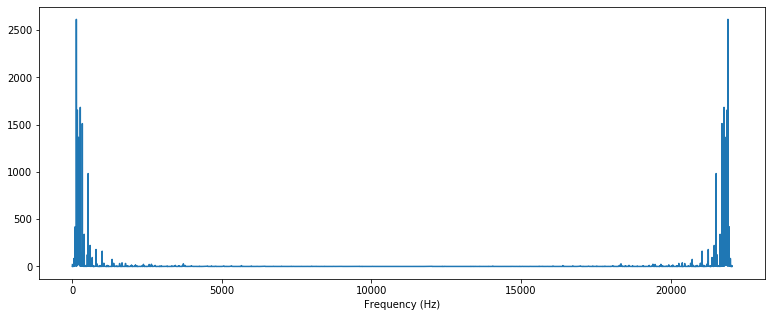

In [9]:
plt.figure(figsize=(13, 5))
plt.plot(f, X_mag) # magnitude spectrum
plt.xlabel('Frequency (Hz)')
plt.show()

NOTE: the spectrum is symmetrical around sr/2. According to sampling frequency, the max frequency that can be captured by a digital signal with sampling rate of sr is sr/2.

Zooming in, let's inspect the frequency bands at the lower end of the spectrum:

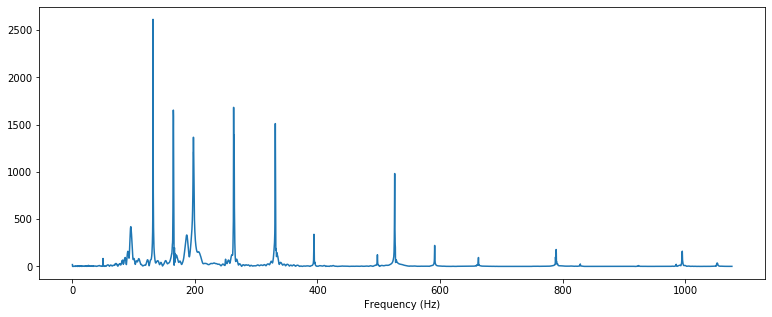

In [11]:
plt.figure(figsize=(13, 5))
plt.plot(f[:5000], X_mag[:5000])
plt.xlabel('Frequency (Hz)')
plt.show()

Note: this sample has six large peaks, likely corresponding to the six strings of the guitar sounding the chord.

What is the value of the largest peak (leftmost) in Hz?

In [12]:
# index of the maximum value in time series
max_pos = X_mag.argmax()

# frequency at the same index
f[max_pos]

131.56915594878856

What is this frequency as a musical note?

In [13]:
librosa.hz_to_note(f[max_pos])

'C3'

EXERCISE: Find the indices of the six largest peaks, and compute their corresponding frequencies and musical notes. Do those notes correspond to the expected components of a guitar C chord strum?

See the [frequency-transforms.ipynb](frequency-transforms.ipynb) notebook for a more complete example of different feature transfer types.

## Mel Frequency Ceptral Coefficients

In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

The [mel frequency cepstral coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCCs) of a signal are a small set of features (usually about 10-20) which concisely describe the overall shape of a spectral envelope (i.e. how the spectral envelope is evolving). In MIR, it is often used to describe timbre.

They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum"). The difference between the cepstrum and the mel-frequency cepstrum is that in the MFC, the frequency bands are equally spaced on the mel scale, which approximates the human auditory system's response more closely than the linearly-spaced frequency bands used in the normal cepstrum.

Let's load, display, and play an audio file:

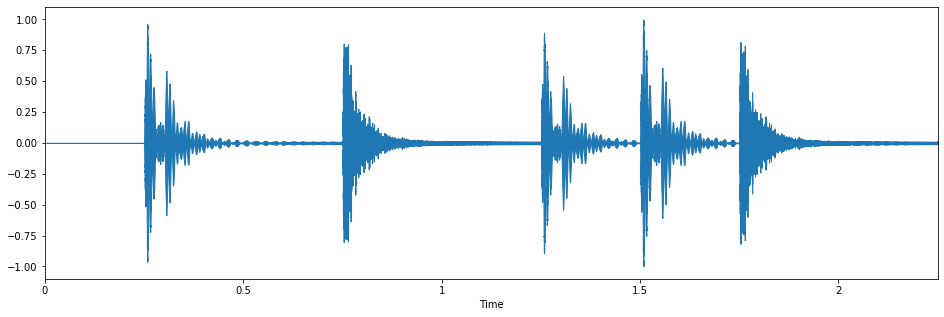

In [19]:
# load
x, fs = librosa.load('audio/simple_loop.wav')

# display
plt.figure(figsize=(16, 5))
librosa.display.waveplot(x, sr=fs)
plt.show()

# play
Audio(x, rate=fs)

To copmute MFCCs across an audio signal, we can use [`librosa.feature.mfcc`](http://bmcfee.github.io/librosa/generated/librosa.feature.mfcc.html#librosa.feature.mfcc):

In [21]:
fs

22050

In [15]:
mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)

(20, 97)


In this case, `mfcc` computed 20 MFCCs over 130 frames.

The very first MFCC, the 0th coefficient, does not convey information relevant to the overall shape of the spectrum. It only conveys a constant offset, i.e. adding a constant value to the entire spectrum. Therefore, many practitioners will discard the first MFCC when performing classification. For now, we will use the MFCCs as is.

Let's display the MFCCs:

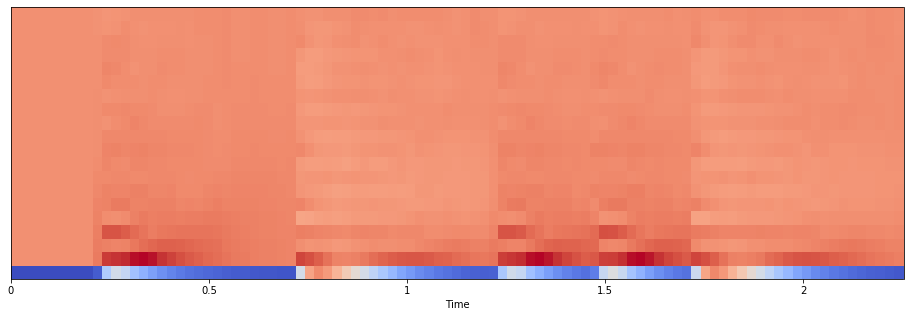

In [16]:
plt.figure(figsize=(16, 5))
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.show()

Let's scale the MFCCs such that each coefficient dimension has zero mean and unit variance (using [`sklearn.preprocessing.scale`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html):

In [17]:
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print("mean:", mfccs.mean(axis=1))
print("var:", mfccs.var(axis=1))

mean: [-3.6868852e-09  1.2289617e-09  6.1448086e-10  0.0000000e+00
 -7.7578211e-09  2.7651639e-08  9.2172131e-10 -2.0277868e-08
  2.0277868e-08  4.2399179e-08 -2.4924880e-08  7.5273903e-09
 -1.8434426e-09  2.2121311e-08 -6.1448086e-10  1.1982377e-08
 -1.5362021e-10  9.9853139e-09 -5.6839480e-09 -7.0665300e-09]
var: [1.0000002  1.0000001  0.9999998  1.0000001  0.99999976 0.9999998
 1.0000001  1.         0.9999997  0.99999994 1.0000001  1.0000001
 0.9999995  1.         1.0000001  1.         0.99999976 1.0000002
 1.0000001  1.        ]


//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
//anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:190: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


Let's plot the scaled MFCCs:

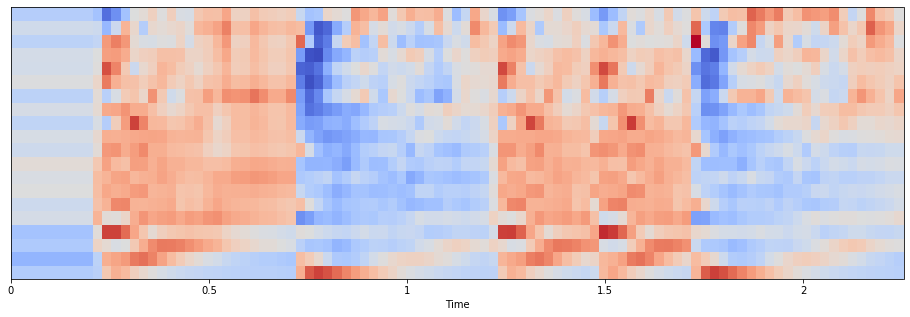

In [18]:
plt.figure(figsize=(16, 5))
librosa.display.specshow(mfccs, sr=fs, x_axis='time')
plt.show()

NOTE: We can use these scaled MFCCs as direct features input to classifiers and clustering algorithms.

# Spectral Features

For classification, we're going to be using new features in our arsenal: spectral moments (centroid, bandwidth, skewness, kurtosis) and other spectral statistics.

[Moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) is a term used in physics and statistics. There are raw moments and central moments. You are probably already familiar with two examples of moments: mean and variance. The first raw moment is known as the mean. The second central moment is known as the variance. 

These Spectral features are calculated on magnitudes of the frequency components of signals.

## Spectral Centroid

Load an audio file:

In [ ]:
x, sr = librosa.load('audio/simple_loop.wav')
Audio(x, rate=sr)

The **spectral centroid** ([Wikipedia](https://en.wikipedia.org/wiki/Spectral_centroid)) indicates at which frequency the energy of a spectrum is centered upon. This is like a weighted mean:

$$ f_c = \frac{\sum_k S(k) f(k)}{\sum_k S(k)} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$.

[`librosa.feature.spectral_centroid`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_centroid.html#librosa.feature.spectral_centroid) computes the spectral centroid for each frame in a signal:

In [ ]:
spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
spectral_centroids.shape

Compute the time variable for visualization:

In [ ]:
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

Define a helper function to normalize the spectral centroid for visualization:

In [ ]:
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Plot the spectral centroid along with the waveform:

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

Similar to the zero crossing rate, there is a spurious rise in spectral centroid at the beginning of the signal. That is because the silence at the beginning has such small amplitude that high frequency components have a chance to dominate. One hack around this is to add a small constant before computing the spectral centroid, thus shifting the centroid toward zero at quiet portions:

In [ ]:
plt.figure(figsize=(14, 5))
spectral_centroids = librosa.feature.spectral_centroid(x+0.01, sr=sr)[0]
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r') # normalize for visualization purposes
plt.show()

In [ ]:
print("mean spectral centroid: {:0.2f} Hz".format(np.mean(spectral_centroids)))

## Spectral Bandwidth

[`librosa.feature.spectral_bandwidth`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_bandwidth.html#librosa.feature.spectral_bandwidth) computes the order-$p$ spectral bandwidth:

$$ \left( \sum_k S(k) \left(f(k) - f_c \right)^p \right)^{\frac{1}{p}} $$

where $S(k)$ is the spectral magnitude at frequency bin $k$, $f(k)$ is the frequency at bin $k$, and $f_c$ is the spectral centroid. When $p = 2$, this is like a weighted standard deviation.

In [ ]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(x+0.01, sr=sr, p=4)[0]

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth_2), color='r')
plt.plot(t, normalize(spectral_bandwidth_3), color='g')
plt.plot(t, normalize(spectral_bandwidth_4), color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.show()

In [ ]:
print("mean spectral bandwidth: {:0.2f} Hz".format(np.mean(spectral_bandwidth_2)))

## Spectral Rolloff

**Spectral rolloff** is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

[`librosa.feature.spectral_rolloff`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_rolloff.html#librosa.feature.spectral_rolloff) computes the rolloff frequency for each frame in a signal:

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(x+0.01, sr=sr)[0]

plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

In [ ]:
print("mean spectral roloff: {:0.2f} Hz".format(np.mean(spectral_rolloff)))

## Spectral Contrast

**Spectral contrast** considers the spectral peak, the spectral valley, and their difference in each frequency subband. For more information:

- [Jiang, Dan-Ning, Lie Lu, Hong-Jiang Zhang, Jian-Hua Tao, and Lian-Hong Cai. “Music type classification by spectral contrast feature.” In Multimedia and Expo, 2002. ICME‘02. Proceedings. 2002 IEEE International Conference on, vol. 1, pp. 113-116. IEEE, 2002.](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.583.7201&rep=rep1&type=pdf)

[`librosa.feature.spectral_contrast`](https://librosa.github.io/librosa/generated/librosa.feature.spectral_contrast.html) computes the spectral contrast for six subbands for each time frame:

In [ ]:
spectral_contrast = librosa.feature.spectral_contrast(x, sr=sr)
spectral_contrast.shape

Display:

In [ ]:
plt.figure(figsize=(14, 5))
plt.imshow(normalize(spectral_contrast, axis=1), aspect='auto', origin='lower', cmap='coolwarm')
plt.show()

## Constant-Q Transform

Unlike the Fourier transform, but similar to the mel scale, the [constant-Q transform](http://en.wikipedia.org/wiki/Constant_Q_transform) uses a logarithmically spaced frequency axis. For more information, read the original paper:

- [Judith C. Brown, "Calculation of a constant Q spectral transform," J. Acoust. Soc. Am., 89(1):425–434, 1991.](http://academics.wellesley.edu/Physics/brown/pubs/cq1stPaper.pdf)

The constant in constant-Q is the ratio between frequency and resolution (i.e. the width of each frequency band changes as the frequency changes). 

Let's load a file:

In [ ]:
x, sr = librosa.load('audio/simple_piano.wav')
Audio(x, rate=sr)

To compute a constant-Q spectrogram, will use [`librosa.cqt`](https://librosa.github.io/librosa/generated/librosa.core.cqt.html#librosa.core.cqt):

In [ ]:
fmin = librosa.midi_to_hz(36)
hop_length = 512
C = librosa.cqt(x, sr=sr, fmin=fmin, n_bins=72, hop_length=hop_length)

Display:

In [ ]:
logC = librosa.amplitude_to_db(np.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
plt.show()

Note: each frequency bin corresponds to one MIDI pitch number.

In [ ]:
logC.shape

Print the magnitudes of each key in the Constant-Q spectrum:

In [ ]:
frame_width = (1.0 / sr * hop_length)
frame_width

In [ ]:
pos = int(2.0 / frame_width)
pos

print values at time frame `pos` in logC:

In [ ]:
logC[:,pos]

plot frequency magnitudes at time frame `pos` as bar plot:

In [ ]:
plt.figure(figsize=(15, 5))
plt.bar(x=range(0,72), height=logC[:,pos])
plt.show()

NOTE: the scale of magnitudes goes from -55 db to 10 db. Read [more about decibels here](https://en.wikipedia.org/wiki/Decibel).

Computing peaks at any point in the Constant-Q time series would reveal dominant notes as pitch peaks.

## Chroma

A [chroma vector](https://en.wikipedia.org/wiki/Chroma_feature) is a typically a 12-element feature vector indicating how much energy of each pitch class {musical notes such as C, C#, D, D#, E, ..., B}, is present in the signal. A chromagram displays the chroma pitch magnitudes in the frequency spectrum of an audio signal over time.

Librosa has a function to generate a chromagram: [`librosa.feature.chroma_stft`](https://librosa.github.io/librosa/generated/librosa.feature.chroma_stft.html#librosa.feature.chroma_stft):

In [ ]:
chromagram = librosa.feature.chroma_stft(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

Librosa can also generate a chromagram using the Constant-Q frequency transform: [`librosa.feature.chroma_cqt`](https://librosa.github.io/librosa/generated/librosa.feature.chroma_cqt.html#librosa.feature.chroma_cqt)

In [ ]:
chromagram = librosa.feature.chroma_cqt(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

Chroma energy normalized statistics (CENS): The main idea of CENS features is that taking statistics over large windows smooths local deviations in tempo, articulation, and musical ornaments such as trills and arpeggiated chords. CENS are best used for tasks such as audio matching and similarity.

[`librosa.feature.chroma_cens`](https://librosa.github.io/librosa/generated/librosa.feature.chroma_cens.html#librosa.feature.chroma_cens)

In [ ]:
chromagram = librosa.feature.chroma_cens(x, sr=sr, hop_length=hop_length)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
plt.show()

## References
- International Society for Music Information Retrieval (ISMIR) [https://ismir.net/](https://ismir.net/)
- Laboratory for the Recognition and Organization of Speech and Audio at Columbia University: [LabROSA](https://labrosa.ee.columbia.edu/)
  - LibROSA [https://librosa.github.io/librosa/](https://librosa.github.io/librosa/)
- Brian McFee - SciPy 2015 Talk on Audio Processing and MIR with LibROSA: https://www.youtube.com/watch?v=MhOdbtPhbLU
  - [website](https://bmcfee.github.io/) [paper](https://bmcfee.github.io/papers/scipy2015_librosa.pdf)
